Assuming 'kulina_data.csv' has the following columns:
| Column Name      | Data Type  | Description                                                |
| ---------------- | ---------- | ---------------------------------------------------------- |
| `user_id`        | int or str | Unique identifier for each user                            |
| `total_quantity` | int        | Total number of items purchased by the user                |
| `total_spend`    | float      | Total amount of money spent by the user (in your currency) |

you can following this postgresql to get data :
```-- Aggregate total quantity and total spend per user
SELECT
    user_id,
    SUM(kod.quantity) AS total_quantity,
    SUM(kp.price) AS total_spend
FROM ku_order
JOIN public.ku_order_detail kod on ku_order.id = kod.order_id
JOIN public.ku_product kp on kod.product_id = kp.id
GROUP BY user_id
ORDER BY user_id;
```


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import nbinom, lognorm

In [17]:
df = pd.read_csv("kulina_data.csv")  # columns: user_id, total_quantity, total_spend

print("Data head:")
print(df.head())

print("\nData description:")
print(df.describe())

Data head:
   user_id  total_quantity  total_spend
0        1               4      1239.38
1        2              95     59041.49
2        3               3        52.10
3        4               5      1713.30
4        5               4      2199.82

Data description:
             user_id  total_quantity    total_spend
count   28306.000000    28306.000000   28306.000000
mean    86430.266269       24.787713   17429.936771
std     30428.158207       67.911845   28348.196923
min         1.000000       -3.000000      36.610000
25%     71538.000000        4.000000    2815.352500
50%     89225.500000        9.000000    6765.450000
75%    107529.500000       25.000000   18814.350000
max    139605.000000     4078.000000  469156.610000


In [18]:
summary = pd.DataFrame({
    "Column": df.columns,
    "Data Type": [df[col].dtype for col in df.columns],
    "Missing Values": [df[col].isnull().sum() for col in df.columns],
    "Unique Values": [df[col].nunique() for col in df.columns]
})
print("\n=== Column Summary ===")
print(summary)


=== Column Summary ===
           Column Data Type  Missing Values  Unique Values
0         user_id     int64               0          28306
1  total_quantity     int64               0            361
2     total_spend   float64               0          12919


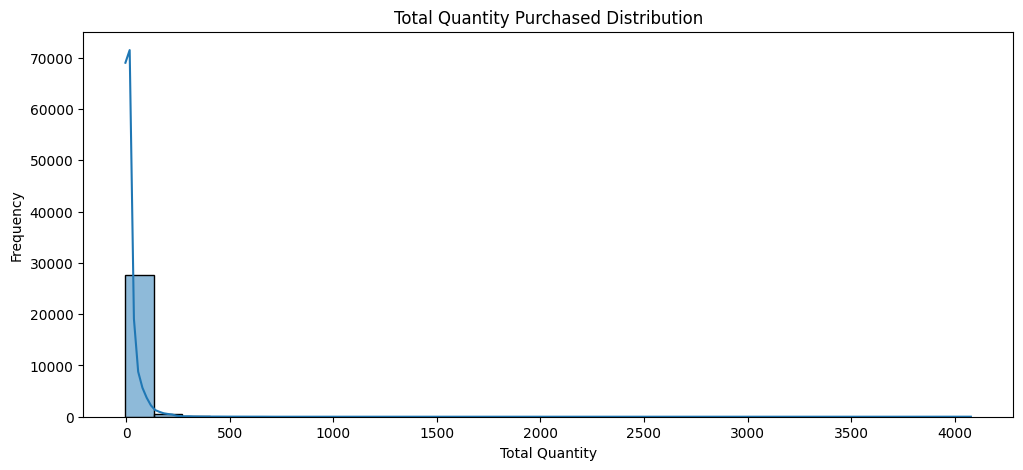

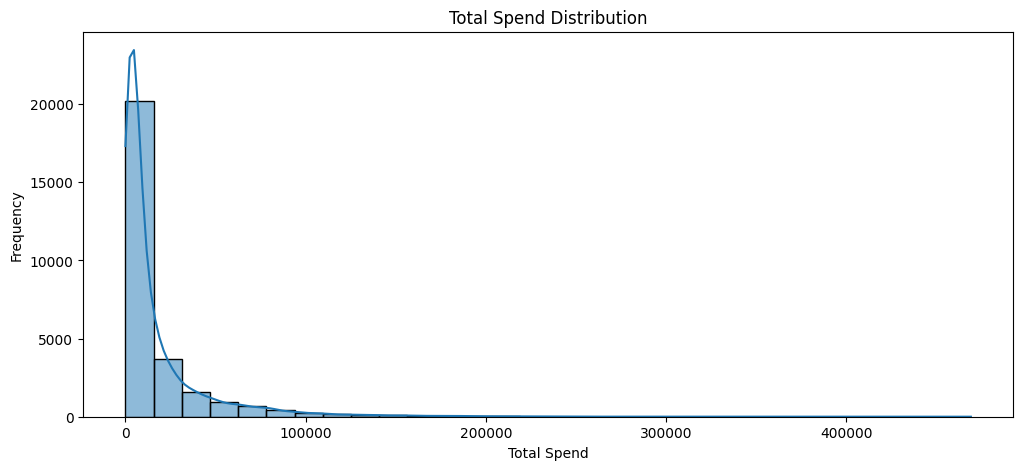

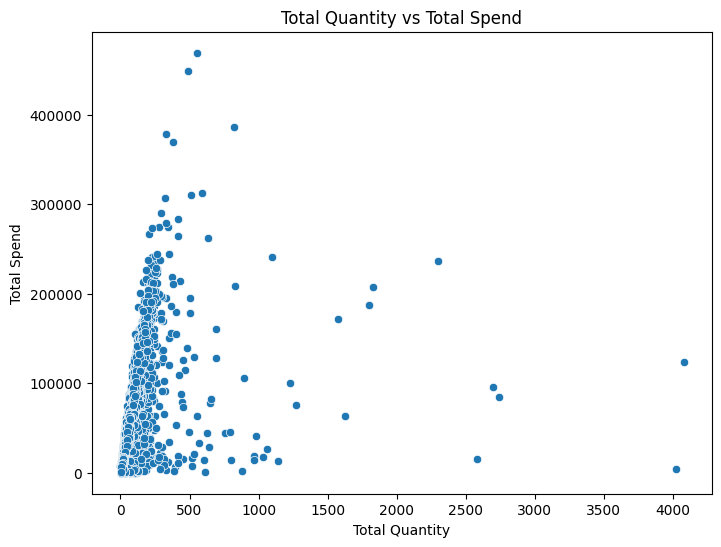

In [19]:
plt.figure(figsize=(12,5))
sns.histplot(df['total_quantity'], kde=True, bins=30)
plt.title("Total Quantity Purchased Distribution")
plt.xlabel("Total Quantity")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['total_spend'], kde=True, bins=30)
plt.title("Total Spend Distribution")
plt.xlabel("Total Spend")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='total_quantity', y='total_spend')
plt.title("Total Quantity vs Total Spend")
plt.xlabel("Total Quantity")
plt.ylabel("Total Spend")
plt.show()


Negative Binomial fit for total_quantity: r=0.13, p=0.0054


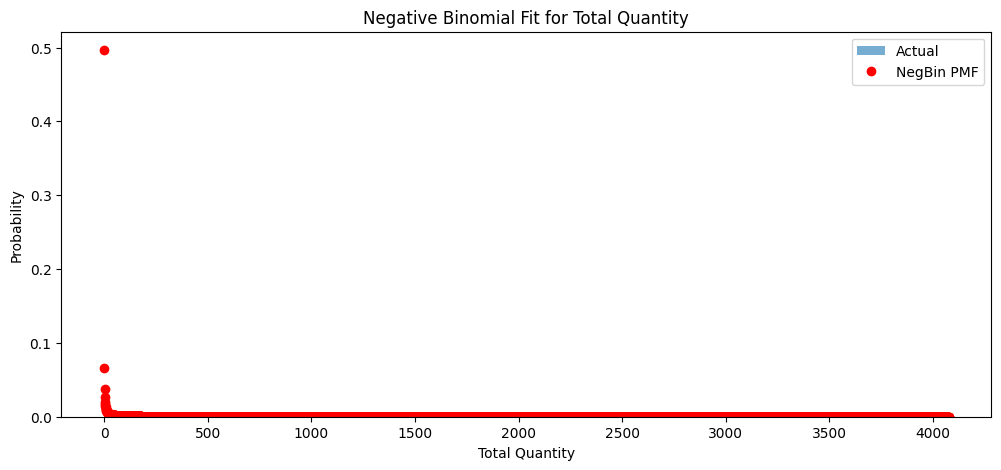

In [20]:
quantity = df['total_quantity'].values
mean_q = quantity.mean()
var_q = quantity.var()

# Method-of-moments estimation
r = mean_q**2 / (var_q - mean_q) if var_q > mean_q else 1e6  # if variance <= mean, approximate Poisson
p = r / (r + mean_q)

print(f"\nNegative Binomial fit for total_quantity: r={r:.2f}, p={p:.4f}")

# PMF for visualization
x_q = np.arange(0, quantity.max() + 1)
nb_pmf = nbinom.pmf(x_q, r, p)

plt.figure(figsize=(12,5))
plt.hist(quantity, bins=30, density=True, alpha=0.6, label='Actual')
plt.plot(x_q, nb_pmf, 'ro', label='NegBin PMF')
plt.title("Negative Binomial Fit for Total Quantity")
plt.xlabel("Total Quantity")
plt.ylabel("Probability")
plt.legend()
plt.show()

- r = 0.13, p = 0.0054

    Very small r → highly overdispersed data (variance >> mean).
    
    Low p → heavy tail: a small fraction of users buy a lot, most buy little.

- Interpretation: Most users purchase small quantities, but a few users purchase very large quantities. This aligns with typical online food ordering behavior.


Log-Normal fit for total_spend: shape=1.42, scale=6968.17


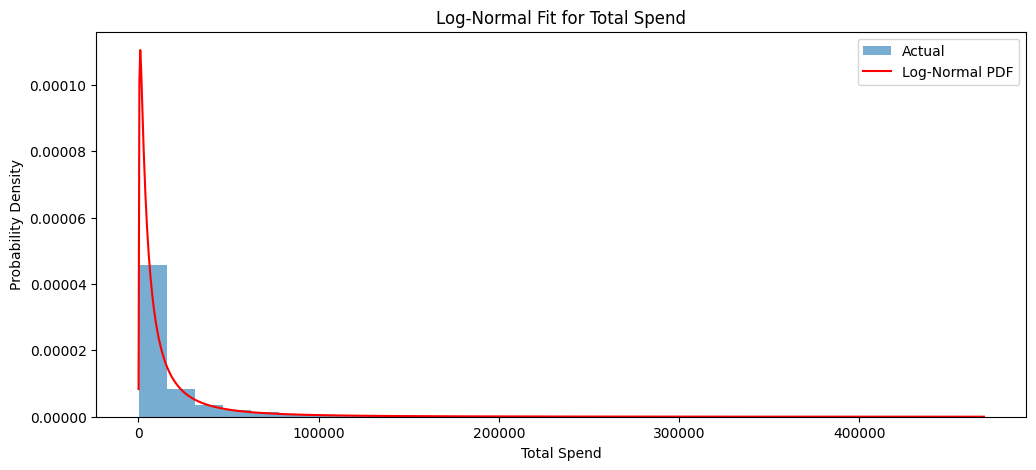

In [21]:
spend = df['total_spend'].values
spend_pos = spend[spend > 0]  # log-transform requires positive values

shape, loc, scale = lognorm.fit(spend_pos, floc=0)
print(f"\nLog-Normal fit for total_spend: shape={shape:.2f}, scale={scale:.2f}")

x_s = np.linspace(spend_pos.min(), spend_pos.max(), 1000)
pdf_s = lognorm.pdf(x_s, shape, loc=loc, scale=scale)

plt.figure(figsize=(12,5))
plt.hist(spend_pos, bins=30, density=True, alpha=0.6, label='Actual')
plt.plot(x_s, pdf_s, 'r-', label='Log-Normal PDF')
plt.title("Log-Normal Fit for Total Spend")
plt.xlabel("Total Spend")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

- shape = 1.42, scale = 6968.17

    Right-skewed distribution: most users spend moderately, but some spend very high amounts.

    Log-Normal is ideal here because spend cannot be negative and shows multiplicative variability.

- Interpretation: A few high-spending users (top 5–10%) contribute a large portion of revenue.